In [20]:
import pandas as pd
import numpy as np

In [21]:
def read_to_numpy_with_headers(file_path):
    df = None
    if (file_path[-5:] == '.xlsx'):
        df = pd.read_excel(file_path)
    elif (file_path[-4:] == '.csv'):
        df = pd.read_csv(file_path)
    columns_to_drop = ['Date', 'CodaType', 'Unit', 'UnitNum', 'IDN'] # + ['Clan', ]
    df = df.drop(columns_to_drop, axis=1)
    headers = df.columns.values  # Extract headers

    return df, headers

In [62]:
file_path = "../../../data/dominica-sharma.csv"
initial_df, headers = read_to_numpy_with_headers(file_path)

initial_df.shape, headers

((8719, 13),
 array(['codaNUM2018', 'nClicks', 'Duration', 'ICI1', 'ICI2', 'ICI3',
        'ICI4', 'ICI5', 'ICI6', 'ICI7', 'ICI8', 'ICI9', 'Clan'],
       dtype=object))

In [37]:
all_tempos = initial_df['Duration'].astype(float)

# Extract the clan labels from the dataset
clans = initial_df['Clan']

# Only use codas (tempos) from the EC1 clan
all_tempos_labelled = []

for i in range(len(clans)):
    if clans[i] == 'EC1':  # Check if the clan is 'EC1'
        all_tempos_labelled.append(all_tempos[i])

# Filter out anomalous annotations by limiting tempos to a specific range
all_tempos_ec1 = []

# Loop through all EC1 clan tempos and apply the filtering criteria
for i in range(len(all_tempos_labelled)):
    if 0.1 < all_tempos_labelled[i] < 1.75:  # Only keep tempos between 0.1 and 1.75
        all_tempos_ec1.append(all_tempos_labelled[i])

f"Number of codas from the EC1 clan: {len(all_tempos_ec1)}"

'Number of codas from the EC1 clan: 7737'

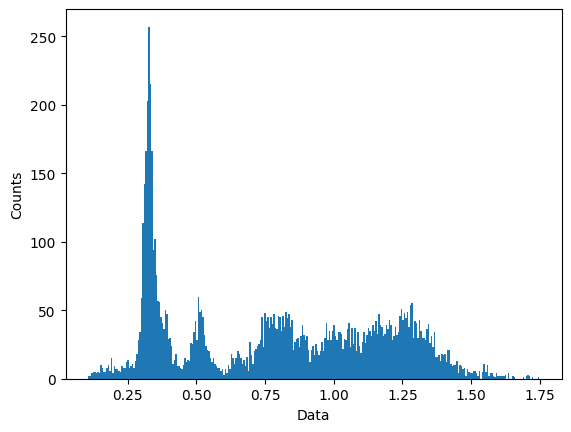

In [57]:
import matplotlib.pyplot as plt

# Plot the histogram with 300 bins to show distribution of tempo values
plt.hist(all_tempos_ec1, bins=300)
plt.ylabel('Counts')
plt.xlabel('Data')
plt.show()

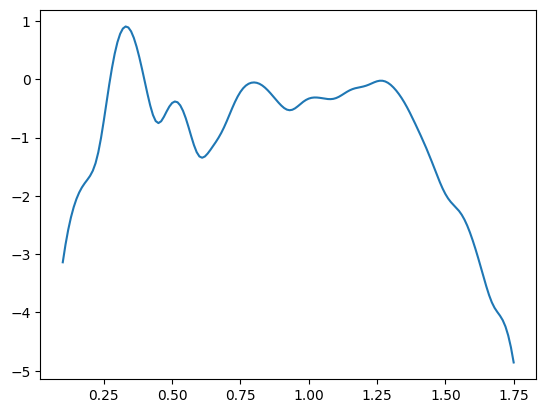

In [39]:
from numpy import array
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot

a = array(all_tempos_ec1).reshape(-1, 1)

# Apply Kernel Density Estimation (KDE) with a Gaussian kernel to estimate the probability density function of the tempos
kde = KernelDensity(kernel='gaussian', bandwidth=0.035).fit(a)

# Create a range of values (s) over which to evaluate the KDE, spanning the tempo range from 0.1 to 1.75
s = np.arange(0.1, 1.75 + 0.01, 0.01)

# Evaluate the log density (e) of the KDE at each point in 's'
e = kde.score_samples(s.reshape(-1, 1))

# Plot the KDE results, showing how the probability density varies across the tempo range
plot(s, e)
plt.show()

In [40]:
from scipy.signal import argrelextrema

# Identify local minima and maxima in the estimated log density (e)
# 'argrelextrema' finds indices of relative extrema (minima or maxima) in an array

# Find indices of local minima in the density estimate 'e'
mi = argrelextrema(e, np.less)[0]

# Find indices of local maxima in the density estimate 'e'
ma = argrelextrema(e, np.greater)[0]

# This gives the tempo values where the density changes from increasing to decreasing (maxima)
# or decreasing to increasing (minima)
print("Minima:", s[mi])
print("Maxima:", s[ma])

Minima: [0.45 0.61 0.93 1.08]
Maxima: [0.33 0.51 0.8  1.02 1.26]


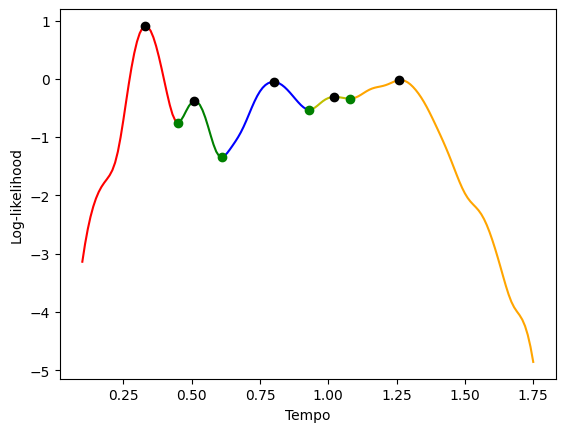

In [41]:
# Plot segments of the KDE curve between each pair of local minima (mi) using different colors

plot(s[:mi[0]+1], e[:mi[0]+1], 'r')
plot(s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g')
plot(s[mi[1]:mi[2]+1], e[mi[1]:mi[2]+1], 'b')
plot(s[mi[2]:mi[3]+1], e[mi[2]:mi[3]+1], 'y')
plot(s[mi[3]:], e[mi[3]:], 'orange')
plot(s[ma], e[ma], 'ko')
plot(s[mi], e[mi], 'go')

plt.ylabel("Log-likelihood")
plt.xlabel("Tempo")
plt.show()

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tempo_clustering(intervals, all_tempos):
    # Define the intervals based on the KDE minima positions
    # These intervals span from the minimum tempo value (0.1) to the maximum (1.75),
    # with each interval boundary set at a local minimum of the KDE curve.
    intervals = [0.1, *intervals, 1.75]

    plt.figure()
    # Define colors for each interval to match the KDE segmentation
    colors = ['red', 'green', 'blue', 'yellow', 'orange', 'violet', 'brown', 'pink']

    # Plot a histogram for each interval with a different color
    for i in range(len(intervals) - 1):
        # Filter all tempos to include only data points within the current interval
        interval_data = [tempo for tempo in all_tempos if intervals[i] <= tempo < intervals[i + 1]]
        plt.hist(interval_data, bins=100, color=colors[i], alpha=0.7, label=f"{intervals[i]:.2f} - {intervals[i+1]:.2f}")

    plt.ylabel('Counts')
    plt.xlabel('Data')
    plt.legend(title="Tempo Intervals")
    plt.show()

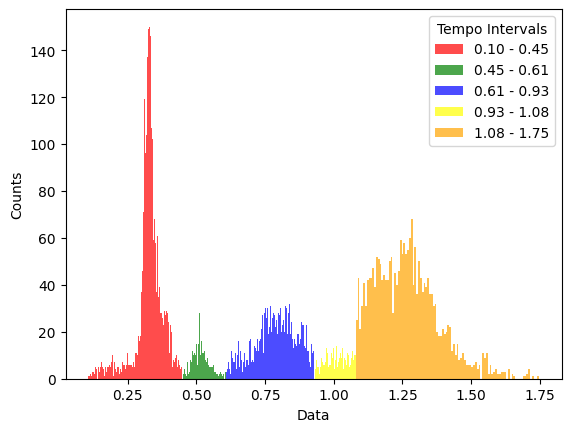

In [47]:
# Define the intervals based on the KDE minima positions
# These intervals span from the minimum tempo value (0.1) to the maximum (1.75),
# with each interval boundary set at a local minimum of the KDE curve.
intervals = [s[mi[0]], s[mi[1]], s[mi[2]], s[mi[3]]]

plot_tempo_clustering(intervals, all_tempos_ec1)

In [30]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Fit GMM to 1D data
data = np.array(all_tempos_ec1).reshape(-1, 1)
gmm = GaussianMixture(n_components=5, random_state=0).fit(data)

# Extract and sort cluster centers
centers = np.sort(gmm.means_.flatten())

# Calculate midpoints between consecutive centers to define interval boundaries
intervals = [(centers[i] + centers[i+1]) / 2 for i in range(len(centers) - 1)]
print("GMM interval boundaries:", intervals)

GMM interval boundaries: [np.float64(0.42199938413500837), np.float64(0.6527498902008119), np.float64(0.9328104348632442), np.float64(1.1828650873593871)]


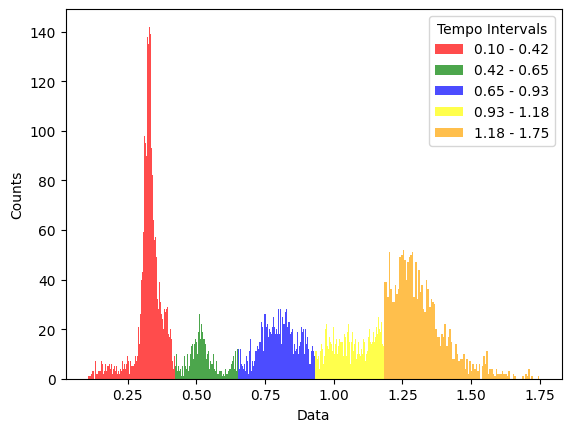

In [31]:
plot_tempo_clustering(intervals, all_tempos_ec1)

In [32]:
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks
import numpy as np

# Fit KDE to 1D data
kde = KernelDensity(kernel='gaussian', bandwidth=0.035).fit(data)

# Create a range of values for KDE
s = np.linspace(min(data), max(data), 1000).reshape(-1, 1)
density = kde.score_samples(s)

# Identify peaks in KDE
peaks, _ = find_peaks(density)
peak_values = s[peaks].flatten()

# Sort peaks and find midpoints between consecutive peaks
peak_values.sort()
intervals = [(peak_values[i] + peak_values[i+1]) / 2 for i in range(len(peak_values) - 1)]
print("KDE interval boundaries:", intervals)

KDE interval boundaries: [np.float64(0.42145088583583584), np.float64(0.6554169001001001), np.float64(0.9115481157157157), np.float64(1.143872263213213)]


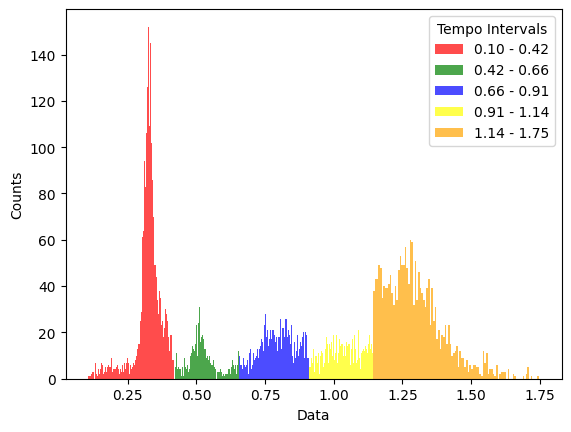

In [33]:
plot_tempo_clustering(intervals, all_tempos_ec1)

In [34]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Fit Agglomerative Clustering on 1D data
agg_clustering = AgglomerativeClustering(n_clusters=5)
labels = agg_clustering.fit_predict(data)

# Calculate the mean of each cluster
centers = np.array([data[labels == i].mean() for i in range(5)])
centers.sort()

# Calculate midpoints between consecutive centers to define intervals
intervals = [(centers[i] + centers[i+1]) / 2 for i in range(len(centers) - 1)]
print("Agglomerative interval boundaries:", intervals)


Agglomerative interval boundaries: [np.float64(0.4235497942601019), np.float64(0.6618966956953991), np.float64(0.9164644387082277), np.float64(1.1522860392244383)]


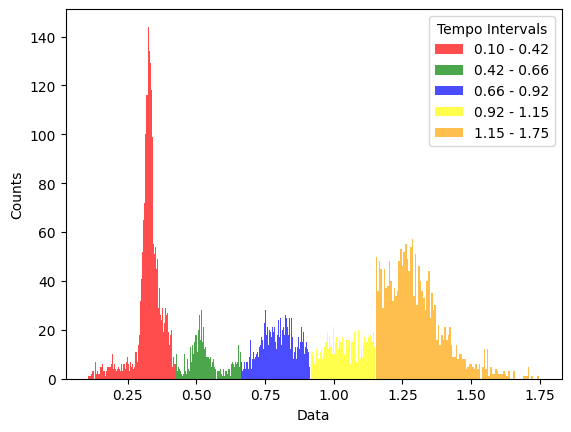

In [35]:
plot_tempo_clustering(intervals, all_tempos_ec1)